# Days spent in the ICU for all patients
We want to create a table, for all patients, that counts each day being spent in the ICU, and also assign a timestamp to the start of each day. In other words, the table should contain the following information (but then for each patient):
- The unique identifier of the ICU stay
- Time of admission to the ICU
- Time of discharge from the ICU
- Column that counts the days since arrival in the ICU
- Column that counts down to the day of discharge from the ICU
- Timestamp at the start of the day
- Timestamp at the end of the day

### SQL query description
All information that is needed is available in the Icustays table. We select all unique ICU stay identifiers, along with the time of admission, time of discharge and length of stay in the ICU. Using the time of admission and length of stay, we can create two new variables to count the number of days since arrival in and down to discharge from the ICU. Using these counters, we can obtain the timestamps. 

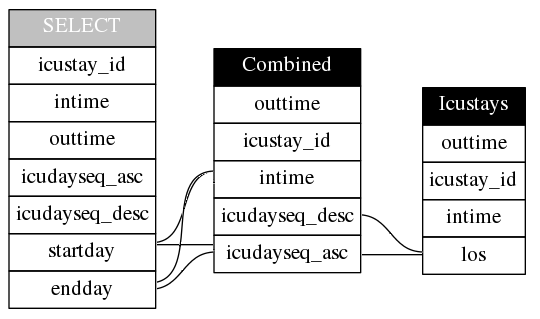

In [1]:
from IPython.display import Image
Image("../cookbook_queries/SQL_query_diagrams/days_icu.png", width=500)

### Implementation of the above query

In [2]:
# Imports:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mc
import colorsys
import psycopg2
%matplotlib inline

# Configuration:
sqluser = 'postgres'
dbname = 'mimic'
password='postgres'
schema_name = 'mimiciii'

# Connect to MIMIC-III:
con = psycopg2.connect(dbname=dbname, user=sqluser, password=password)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [3]:
# An example of the table would be:
"""
Columns:
-- icustay_id
-- intime
-- outime
-- icudayseq_asc:  Counting days since arrival in the ICU
-- 				   0 = day of arrival in the ICU
--                 1 = day 1 after arrival
--                 2 = day 2 after arrival etc
-- icudayseq_desc: Counting down to the day of discharge from the ICU
--                 2 = day 2 before discharge etc
--                 1 = day 1 before discharge
-- 				   0 = day of discharge from the ICU
-- startday: if day of arrival then intime, else midnight at start of day
-- endday: if day of discharge then outtime, else midnight at end of day
"""

# Query:
query = """
WITH dayseq_table AS (
    SELECT i.icustay_id, i.intime, i.outtime,
       GENERATE_SERIES(0,CEIL(i.los)::INT-1,1) AS icudayseq_asc,
       GENERATE_SERIES(CEIL(i.los)::INT-1,0,-1) AS icudayseq_desc
    FROM mimiciii.icustays i)
SELECT d.icustay_id, d.intime, d.outtime, d.icudayseq_asc, d.icudayseq_desc,
    CASE WHEN d.icudayseq_asc = 0 THEN d.intime
        ELSE (date_trunc('day', d.intime) + d.icudayseq_asc * INTERVAL '1 DAY')
        END AS startday,
    CASE WHEN d.icudayseq_desc = 0 THEN d.outtime
        ELSE (date_trunc('day', intime) + (d.icudayseq_asc + 1) * INTERVAL '1 DAY')
        END AS endday
FROM dayseq_table d;
"""

query_output = pd.read_sql_query(query, con)
query_output.head()

,icustay_id,intime,outtime,icudayseq_asc,icudayseq_desc,startday,endday
0,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,0,3,2198-02-14 23:27:38,2198-02-15 00:00:00
1,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,1,2,2198-02-15 00:00:00,2198-02-16 00:00:00
2,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,2,1,2198-02-16 00:00:00,2198-02-17 00:00:00
3,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,3,0,2198-02-17 00:00:00,2198-02-18 05:26:11
4,206613,2170-11-05 11:05:29,2170-11-08 17:46:57,0,3,2170-11-05 11:05:29,2170-11-06 00:00:00
